Extracting features...


C:\Users\gugu1\AppData\Local\Temp\ipykernel_42280\3615764149.py:279: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_train = torch.tensor(X_train, dtype=torch.float32)


Training the classifier...
Epoch [1/20], Training Loss: 2.1394, Validation Loss: 4.5578, Top-1 Accuracy: 0.2250, Top-4 Accuracy: 0.4400
Epoch [2/20], Training Loss: 0.8148, Validation Loss: 4.7088, Top-1 Accuracy: 0.2800, Top-4 Accuracy: 0.5400
Epoch [3/20], Training Loss: 0.6010, Validation Loss: 4.9596, Top-1 Accuracy: 0.2900, Top-4 Accuracy: 0.5350
Epoch [4/20], Training Loss: 0.4961, Validation Loss: 5.0127, Top-1 Accuracy: 0.3100, Top-4 Accuracy: 0.5700
Epoch [5/20], Training Loss: 0.4245, Validation Loss: 5.1749, Top-1 Accuracy: 0.3350, Top-4 Accuracy: 0.5650
Epoch [6/20], Training Loss: 0.3795, Validation Loss: 5.2461, Top-1 Accuracy: 0.3500, Top-4 Accuracy: 0.6000
Epoch [7/20], Training Loss: 0.3481, Validation Loss: 5.1140, Top-1 Accuracy: 0.3600, Top-4 Accuracy: 0.6100
Epoch [8/20], Training Loss: 0.3217, Validation Loss: 5.3292, Top-1 Accuracy: 0.3650, Top-4 Accuracy: 0.5950
Epoch [9/20], Training Loss: 0.2907, Validation Loss: 5.3621, Top-1 Accuracy: 0.3750, Top-4 Accuracy:

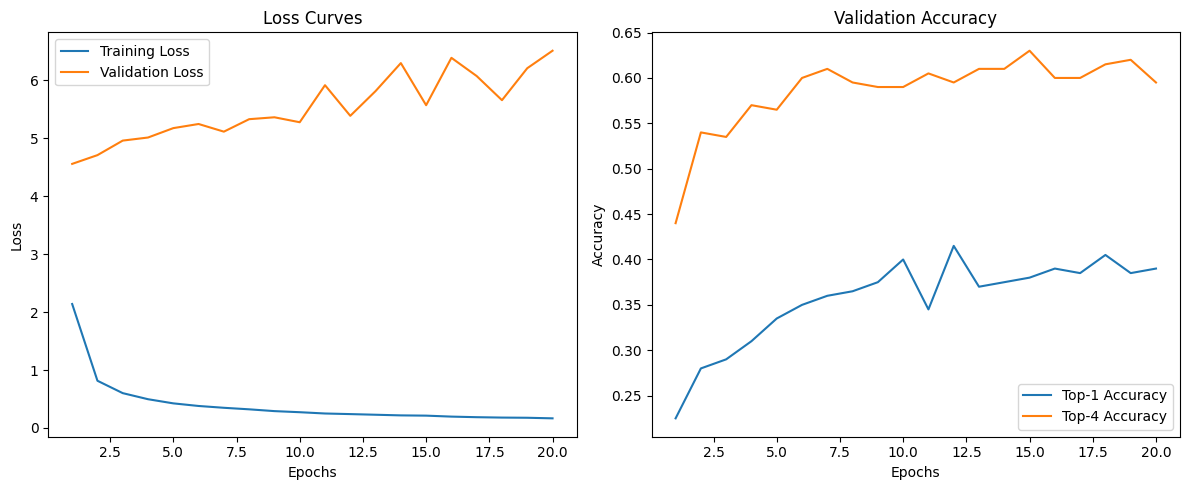

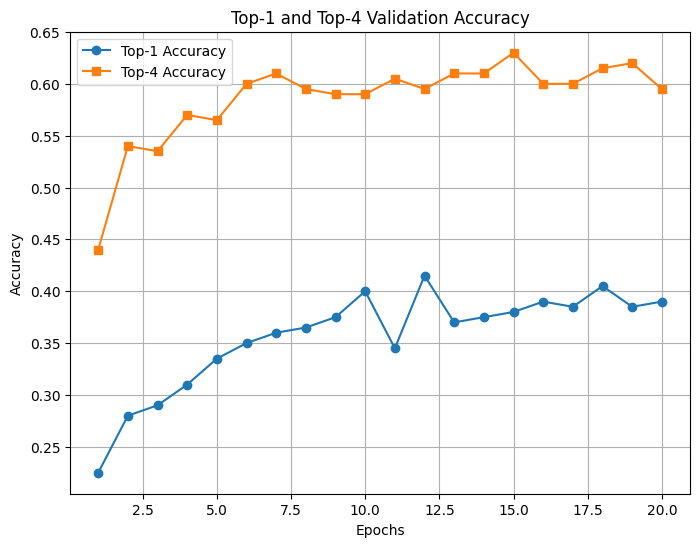

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pymongo import MongoClient
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from scipy.fft import fft
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

import random 

def generate_gaze_points(
    word, 
    key_positions, 
    num_points=None,  
    fixation_points_per_key=10, 
    gauss_std=15, 
    gauss_std_center=20,
    saccade_points_min=1, 
    saccade_points_max=2,
    wrong_key_probability=0.2, 
    wrong_key_fixation_points=4
):
    gaze_points = []

    word = word.upper()

    all_x_positions = [pos[0] for pos in key_positions.values()]
    center_x = (max(all_x_positions) + min(all_x_positions)) / 2

    def adjust_extreme_positions(pos):
        x, y = pos
        threshold = (max(all_x_positions) - min(all_x_positions)) * 0.3
        distance_from_center = x - center_x
        if abs(distance_from_center) > threshold:
            adjustment_factor = 0.2
            x -= adjustment_factor * distance_from_center
        return (x, y)

    start_key = 'BOTAO_ACABAR'
    if start_key not in key_positions:
        print(f"Key '{start_key}' not found in key_positions.")
        return gaze_points

    start_pos = adjust_extreme_positions(key_positions[start_key])
    for _ in range(fixation_points_per_key):
        start_fixation_x = start_pos[0] + np.random.normal(0, gauss_std_center)
        start_fixation_y = start_pos[1] + np.random.normal(0, gauss_std_center)
        gaze_points.append([start_fixation_x, start_fixation_y])

    previous_key_pos = gaze_points[-1]  

    for char in word:
        if char not in key_positions:
            print(f"Letter '{char}' not found in key_positions.")
            continue

        key_pos = adjust_extreme_positions(key_positions[char])
        current_key_pos = (
            key_pos[0] + np.random.normal(0, gauss_std_center),
            key_pos[1] + np.random.normal(0, gauss_std_center)
        )

        if random.random() < wrong_key_probability:
            wrong_key = random.choice([
                k for k in key_positions if k != char and k in key_positions
            ])
            wrong_key_pos = adjust_extreme_positions(key_positions[wrong_key])
            wrong_key_fixation = (
                wrong_key_pos[0] + np.random.normal(0, gauss_std_center),
                wrong_key_pos[1] + np.random.normal(0, gauss_std_center)
            )

            for _ in range(wrong_key_fixation_points):
                fixation_x = np.random.normal(wrong_key_fixation[0], gauss_std)
                fixation_y = np.random.normal(wrong_key_fixation[1], gauss_std)
                gaze_points.append([fixation_x, fixation_y])

        num_saccades = random.randint(saccade_points_min, saccade_points_max)
        for _ in range(num_saccades):
            t = random.uniform(0, 1)
            dx = current_key_pos[0] - previous_key_pos[0]
            dy = current_key_pos[1] - previous_key_pos[1]

            saccade_x = previous_key_pos[0] + t * dx + np.random.normal(0, gauss_std)
            saccade_y = previous_key_pos[1] + t * dy + np.random.normal(0, gauss_std)
            gaze_points.append([saccade_x, saccade_y])

        for _ in range(fixation_points_per_key):
            fixation_x = np.random.normal(current_key_pos[0], gauss_std)
            fixation_y = np.random.normal(current_key_pos[1], gauss_std)
            gaze_points.append([fixation_x, fixation_y])

        previous_key_pos = gaze_points[-1] 

    end_pos = adjust_extreme_positions(key_positions[start_key])
    current_key_pos = (
        end_pos[0] + np.random.normal(0, gauss_std_center),
        end_pos[1] + np.random.normal(0, gauss_std_center)
    )

    num_saccades = random.randint(saccade_points_min, saccade_points_max)
    for _ in range(num_saccades):
        t = random.uniform(0, 1)
        dx = current_key_pos[0] - previous_key_pos[0]
        dy = current_key_pos[1] - previous_key_pos[1]

        saccade_x = previous_key_pos[0] + t * dx + np.random.normal(0, gauss_std)
        saccade_y = previous_key_pos[1] + t * dy + np.random.normal(0, gauss_std)
        gaze_points.append([saccade_x, saccade_y])

    for _ in range(fixation_points_per_key):
        end_fixation_x = current_key_pos[0] + np.random.normal(0, gauss_std)
        end_fixation_y = current_key_pos[1] + np.random.normal(0, gauss_std)
        gaze_points.append([end_fixation_x, end_fixation_y])

    if num_points is not None:
        current_length = len(gaze_points)
        if current_length > num_points:
            indices = np.round(np.linspace(0, current_length - 1, num_points)).astype(int)
            gaze_points = [gaze_points[i] for i in indices]
        elif current_length < num_points:
            factor = num_points // current_length
            remainder = num_points % current_length
            gaze_points = gaze_points * factor + gaze_points[:remainder]

    return gaze_points

key_width = 160 * 0.75

def generate_key_positions(win_width=2048, win_height=1152, key_width=160 * 0.75, key_height=160 * 0.75, horizontal_spacing=key_width * 0.25, vertical_spacing=200, num_points=100):
    top_row_y = win_height / 2 - vertical_spacing * 1.5
    middle_row_y = top_row_y - vertical_spacing
    bottom_row_y = middle_row_y - vertical_spacing

    row1_labels = ['Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P']
    row2_labels = ['A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L']
    row3_labels = ['Z', 'X', 'C', 'V', 'B', 'N', 'M']

    def calculate_start_x(num_keys):
        total_width = num_keys * key_width + (num_keys - 1) * horizontal_spacing
        return -total_width / 2 + key_width / 2

    def compute_key_positions(labels, start_x, y_pos):
        positions = []
        for i, label in enumerate(labels):
            x = start_x + i * (key_width + horizontal_spacing)
            positions.append((label, [x, y_pos]))
        return positions

    start_x_row1 = calculate_start_x(len(row1_labels))
    start_x_row2 = calculate_start_x(len(row2_labels))
    start_x_row3 = calculate_start_x(len(row3_labels))

    key_positions = {}
    for label, pos in compute_key_positions(row1_labels, start_x_row1, top_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row2_labels, start_x_row2, middle_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row3_labels, start_x_row3, bottom_row_y):
        key_positions[label.upper()] = pos

    key_positions['BOTAO_ACABAR'] = [0, bottom_row_y - vertical_spacing]

    return key_positions

positions = generate_key_positions()

def get_last_n_gestures(db, collection_name, n=5):
    collection = db[collection_name]
    last_n_gestures = list(collection.find().sort('_id', -1).limit(n))
    return last_n_gestures


from sklearn.model_selection import train_test_split

with open('words.txt', 'r') as f:
    words_list = f.readlines()
words_list = [word.strip() for word in words_list]
words_list = words_list

num_synthetic_samples_per_word = 250
num_points = 170
key_positions = positions  

import os
from pymongo import MongoClient
client = MongoClient('adsada')
db = client["wgaze"]
collection = db['batches']

N = 200
last_300_gestures = get_last_n_gestures(db, 'batches', N)
real_gesture_words = []
real_gesture_data = []
for gesture in last_300_gestures:
    if gesture['word'] in words_list:
        real_gesture_words.append(gesture['word'])
        real_gesture_data.append(gesture['data'])
    else:
        continue 

len(real_gesture_words)
from sklearn.preprocessing import MinMaxScaler

synthetic_data =[]
synthetic_labels = []
for word in real_gesture_words:
    for _ in range(num_synthetic_samples_per_word):
        gaze_points = generate_gaze_points(word, key_positions, num_points)
        gaze_points = np.array(gaze_points)
        synthetic_data.append(gaze_points)
        synthetic_labels.append(word)

def pad_or_truncate(gaze_points, num_points):
    if gaze_points.shape[0] > num_points:
        return gaze_points[:num_points]
    else:
        num_points_to_add = num_points - gaze_points.shape[0]
        return np.concatenate((gaze_points, np.zeros((num_points_to_add, 2))))

real_gestures_processed = []
for data in real_gesture_data:
    gaze = np.array(data)
    gaze = pad_or_truncate(gaze, num_points)
    real_gestures_processed.append(gaze)

real_gestures_processed = np.array(real_gestures_processed)
synthetic_data = np.array(synthetic_data)
def normalize_data(data, min_val, max_val):
    return 2 * (data - min_val) / (max_val - min_val) - 1

all_key_positions_x = [pos[0] for pos in positions.values()]
all_key_positions_y = [pos[1] for pos in positions.values()]

min_x, max_x = min(all_key_positions_x), max(all_key_positions_x)
min_y, max_y = min(all_key_positions_y), max(all_key_positions_y)

synthetic_data = normalize_data(synthetic_data, min_x, max_x)
real_gestures_processed = normalize_data(real_gestures_processed, min_x, max_x)


def extract_features(gaze_points):
    x = gaze_points[:, 0]
    y = gaze_points[:, 1]


    features = np.concatenate((x, y))
    return features

print("Extracting features...")
synthetic_features = []
for gaze_points in synthetic_data:
    features = extract_features(gaze_points)
    synthetic_features.append(features)

real_features = []
for gaze_points in real_gestures_processed:
    features = extract_features(gaze_points)
    real_features.append(features)



label_encoder = LabelEncoder()
synthetic_labels_encoded = label_encoder.fit_transform(synthetic_labels)
real_labels_encoded = label_encoder.transform(real_gesture_words)

X_train, X_eval, y_train, y_eval = train_test_split(synthetic_features, synthetic_labels_encoded, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_eval = torch.tensor(real_features, dtype=torch.float32)
y_eval = torch.tensor(real_labels_encoded, dtype=torch.long)



class GazeDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



train_dataset = GazeDataset(X_train, y_train)
test_dataset = GazeDataset(X_eval, y_eval)


#cropei o subset de metade dos dados reais pra combinar pra usar no treino, e os outros 100 pra testar dps
test_to_combine = torch.utils.data.Subset(test_dataset, range(0, 100))
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_to_combine])

only_synthetic_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#continuo usando como validacao aq so os dados reais
eval_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



class ConvClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ConvClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        B, L = x.shape  
        x = x.view(x.size(0), 1, -1)  # add channel dimension
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = x.view(B, -1) 
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = ConvClassifier(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
training_loss = []
validation_loss = []
validation_top1_acc = []
validation_top4_acc = []

print("Training the classifier...")
for epoch in range(num_epochs):
    model.train()
    epoch_training_loss = 0
    for batch_X, batch_y in only_synthetic_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item()
    avg_training_loss = epoch_training_loss / len(combined_loader)
    training_loss.append(avg_training_loss)

    model.eval()
    epoch_val_loss = 0
    correct_top1 = 0
    correct_top4 = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in eval_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
            
            _, preds_top1 = outputs.topk(1, dim=1, largest=True, sorted=True)
            _, preds_top4 = outputs.topk(4, dim=1, largest=True, sorted=True)
            
            #ve quantos tensores foram iguais a preds no batch
            correct_top1 += preds_top1.eq(batch_y.view(-1, 1)).sum().item()
            correct_top4 += preds_top4.eq(batch_y.view(-1, 1).expand_as(preds_top4)).sum().item()
            total += batch_y.size(0)
    avg_val_loss = epoch_val_loss / len(eval_loader)
    validation_loss.append(avg_val_loss)
    
    top1_accuracy = correct_top1 / total
    top4_accuracy = correct_top4 / total
    validation_top1_acc.append(top1_accuracy)
    validation_top4_acc.append(top4_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Top-1 Accuracy: {top1_accuracy:.4f}, Top-4 Accuracy: {top4_accuracy:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), validation_top1_acc, label='Top-1 Accuracy')
plt.plot(range(1, num_epochs+1), validation_top4_acc, label='Top-4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), validation_top1_acc, marker='o', label='Top-1 Accuracy')
plt.plot(range(1, num_epochs+1), validation_top4_acc, marker='s', label='Top-4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Top-1 and Top-4 Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()